# Generate Data Points

The problem is that $\nabla^{2} T(x,y) = 0$ in $(x,y) \in [0,1] \times [0,1]$ with boudnary condition

$$
\begin{cases}
    T(0,y)=150\\
    T(1,y)=0\\
    T(x,1)=50\\
    T(x,0)=100
\end{cases}
$$.

So, define the grid size $N$ and set data grids $(N+1) \times (N+1)$ in given $(0,1) \times (0,1)$ grid. So boundary points at $i=0$ and $i=N$ and updating points is at $i=1 - (N-1)$.


In [41]:
import numpy as np
import matplotlib.pyplot as plt

N = 100
tolerance = 1e-6
max_iterations = 50000

class DataGrid:
    def __init__(self, N):
        self.N = N
        self.h = 1/N
        self.x = np.linspace(0, 1, N+1)
        self.y = np.linspace(0, 1, N+1)
        self.T = np.zeros((N+1, N+1))
        # (j,i) = (x,y)
        self.T[:, 0] = 150 # T(0,y)=150
        self.T[:, N] = 0 # T(1,y)=0
        self.T[0, :] = 50 # T(x,1)=50
        self.T[N, :] = 100 # T(x,0)=100
    
    def show(self):
        X,Y = np.meshgrid(self.x, self.y)
        x_left, y_left = np.meshgrid(self.x[0], self.y)
        x_left = x_left.flatten()
        y_left = y_left.flatten()
        x_right, y_right = np.meshgrid(self.x[self.N], self.y)
        x_right = x_right.flatten()
        y_right = y_right.flatten()
        x_top, y_top = np.meshgrid(self.x, self.y[0])
        x_top = x_top.flatten()
        y_top = y_top.flatten()
        x_bottom, y_bottom = np.meshgrid(self.x, self.y[self.N])
        x_bottom = x_bottom.flatten()
        y_bottom = y_bottom.flatten()
        bc_points_x = np.concatenate([x_left, x_right, x_top, x_bottom], axis=0)
        bc_points_y = np.concatenate([y_left, y_right, y_top, y_bottom], axis=0)

        bc_left = self.T[:, 0]
        bc_right = self.T[:, self.N]
        bc_top = self.T[0, :]
        bc_bottom = self.T[self.N, :]
        bc_values = np.concatenate([bc_left, bc_right, bc_top, bc_bottom], axis=0)

        plt.figure(figsize=(10, 10))
        plt.scatter(X, Y, c='red', marker='.')
        plt.scatter(bc_points_x, bc_points_y, c=bc_values, marker='*', vmin=0, vmax=150)
        plt.colorbar(label='Temperature')
        plt.xlabel('x')
        plt.ylabel('y')
        plt.title('Boundary Points')
        plt.show()

    def update(self, T_new):
        self.T = T_new

    def get_T(self, i, j):
        return self.T[i, j]

    def get_xy(self, i, j):
        return self.x[i], self.y[j]

    def get_T_at_xy(self, x, y):
        i = np.argmin(np.abs(self.x - x))
        j = np.argmin(np.abs(self.y - y))
        return self.T[i, j]

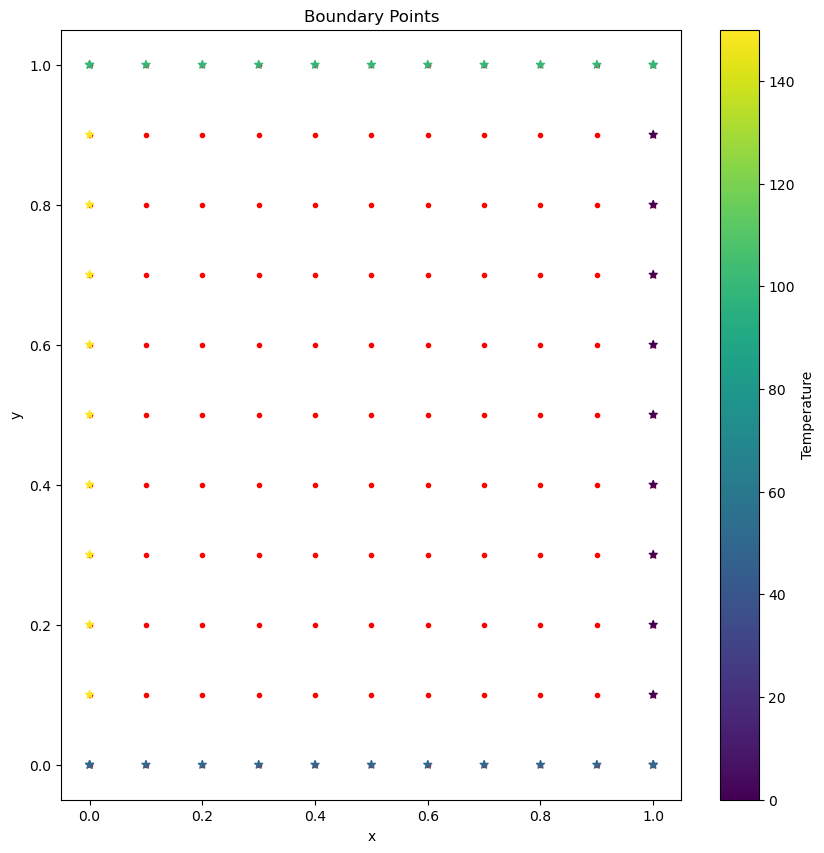

In [35]:
data_grid = DataGrid(10)
data_grid.show()

# Jacobi iteration (Relaxation Method)

$$
\varphi_{i,j}^{n+1} = \frac{1}{4} \left( \varphi_{i+1,j}^{n} + \varphi_{i-1,j}^{n} + \varphi_{i,j+1}^{n} + \varphi_{i,j-1}^{n} \right)
$$

In [64]:
import time
from tqdm import tqdm

class Jacobi:
    def __init__(self, data_grid, error_threshold=1e-6, max_iterations=1000):
        self.data_grid = data_grid
        self.data = data_grid.T
        self.N = data_grid.N
        self.argmax_error = 0
        self.threshold = error_threshold
        self.error_history = []
        self.running_time = 0
        self.max_iterations = max_iterations

    def update(self):
        self.data_new = self.data.copy()
        self.data_new[1:-1, 1:-1] = (self.data[0:-2, 1:-1] + self.data[2:, 1:-1] + self.data[1:-1, 0:-2] + self.data[1:-1, 2:]) / 4
        self.argmax_error = np.max(np.abs(self.data - self.data_new))
        self.error_history.append(self.argmax_error)
        self.data = self.data_new
        if self.argmax_error < self.threshold:
            return True
        return False
    
    def train(self):
        start_time = time.time()
        for i in range(self.max_iterations):
            if self.update():
                end_time = time.time()
                self.running_time = end_time - start_time
                break
        return self.data, self.running_time

    def show_distribution(self):
        plt.imshow(self.data, cmap='jet')
        plt.xlabel('x')
        plt.ylabel('y')
        plt.title('Temperature Distribution')
        plt.colorbar()
        plt.show()

    def show_error_history(self):
        plt.plot(self.error_history)
        plt.xlabel('Iteration (Finished at {})'.format(len(self.error_history)))
        plt.ylabel('Error')
        plt.title('Error History (Tolerance: {})'.format(self.threshold))
        plt.show()


In [44]:
model = Jacobi(DataGrid(N), tolerance, max_iterations)
solution, Run_time_Jacobi = model.train()
print(f"Running time: {Run_time_Jacobi} seconds")

 45%|████▍     | 22291/50000 [00:01<00:01, 19753.79it/s]

Running time: 1.130105972290039 seconds


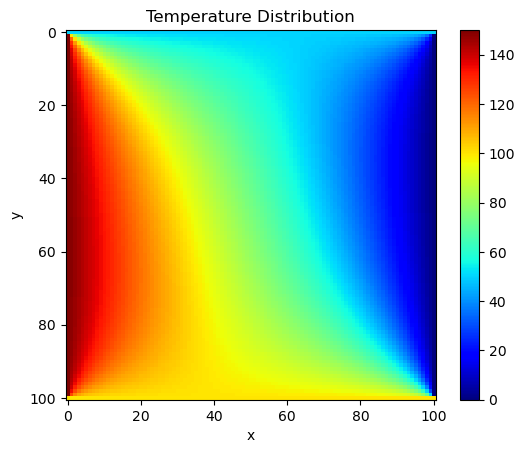

In [45]:
model.show_distribution()

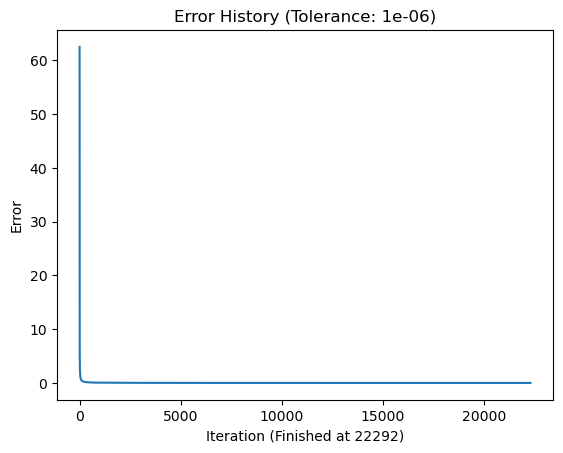

In [46]:
model.show_error_history()

# Gauss-Seidal method

$$
\varphi_{i,j}^{n+1} = \frac{1}{4} \left( \textcolor{red}{\varphi_{i-1,j}^{n+1}} + \varphi_{i+1,j}^{n} + \textcolor{red}{\varphi_{i,j-1}^{n+1}} + \varphi_{i,j+1}^{n} \right)
$$

In [65]:
import numpy as np
import matplotlib.pyplot as plt
import time
from tqdm import tqdm

class GaussSeidel:
    def __init__(self, data_grid, error_threshold=1e-6, max_iterations=1000):
        self.data_grid = data_grid
        self.data = data_grid.T
        self.N = data_grid.N
        self.argmax_error = 0
        self.threshold = error_threshold
        self.error_history = []
        self.running_time = 0
        self.max_iterations = max_iterations
        
    def update(self):
        data_prev = self.data.copy()
        for i in range(1, self.N-1):
            for j in range(1, self.N-1):
                self.data[i, j] = (self.data[i-1, j] + self.data[i+1, j] + self.data[i, j-1] + self.data[i, j+1]) / 4
        self.argmax_error = np.max(np.abs(self.data - data_prev))
        self.error_history.append(self.argmax_error)
        if self.argmax_error < self.threshold:
            return True
        return False
    
    def train(self):
        start_time = time.time()
        for i in range(self.max_iterations):
            if self.update():
                end_time = time.time()
                self.running_time = end_time - start_time
                break
        return self.data, self.running_time
    
    def show_distribution(self):
        plt.imshow(self.data, cmap='jet')
        plt.xlabel('x')
        plt.ylabel('y')
        plt.title('Temperature Distribution')
        plt.colorbar()
        plt.show()
    
    def show_error_history(self):
        plt.plot(self.error_history)
        plt.xlabel('Iteration (Finished at {})'.format(len(self.error_history)))
        plt.ylabel('Error')
        plt.title('Error History (Tolerance: {})'.format(self.threshold))
        plt.show()

In [48]:
model = GaussSeidel(DataGrid(N), tolerance, max_iterations)
solution, Run_time_GaussSeidel = model.train()
print(f"Running time: {Run_time_GaussSeidel} seconds")

 22%|██▏       | 11206/50000 [00:48<02:49, 229.40it/s]

Running time: 48.85051083564758 seconds


In [11]:
print(solution)

[[5.00000000e+01 5.00000000e+01 5.00000000e+01 ... 5.00000000e+01
  5.00000000e+01 5.00000000e+01]
 [1.50000000e+02 9.99776674e+01 8.01900691e+01 ... 2.50111648e+01
  0.00000000e+00 0.00000000e+00]
 [1.50000000e+02 1.19720600e+02 9.99106695e+01 ... 1.51396792e+01
  0.00000000e+00 0.00000000e+00]
 ...
 [1.50000000e+02 7.49888332e+01 4.53297622e+01 ... 2.23306434e-02
  0.00000000e+00 0.00000000e+00]
 [1.50000000e+02 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [1.00000000e+02 1.00000000e+02 1.00000000e+02 ... 1.00000000e+02
  1.00000000e+02 1.00000000e+02]]


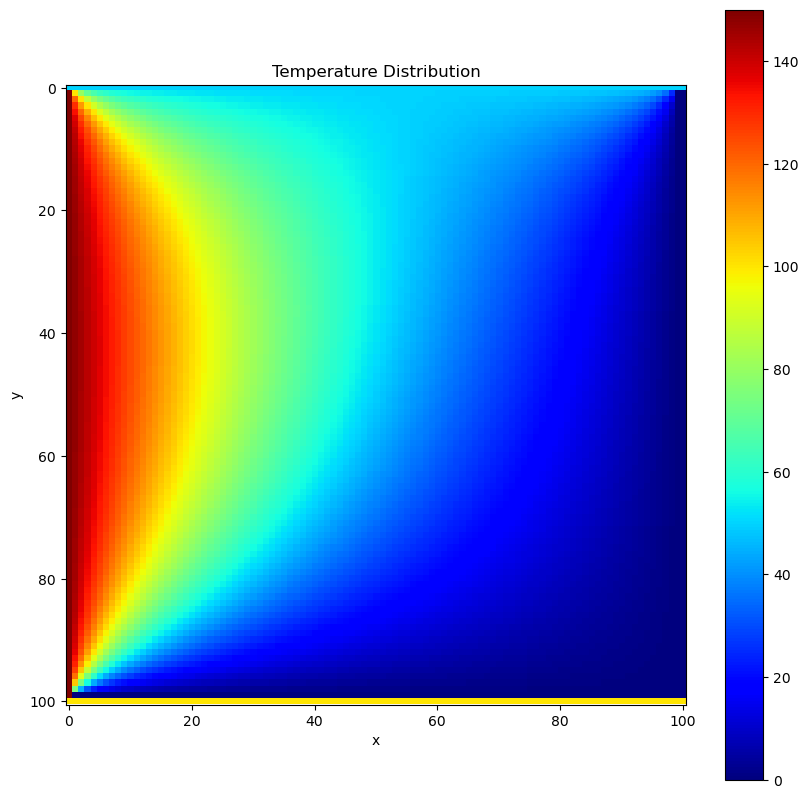

In [49]:
plt.figure(figsize=(10, 10))
model.show_distribution()

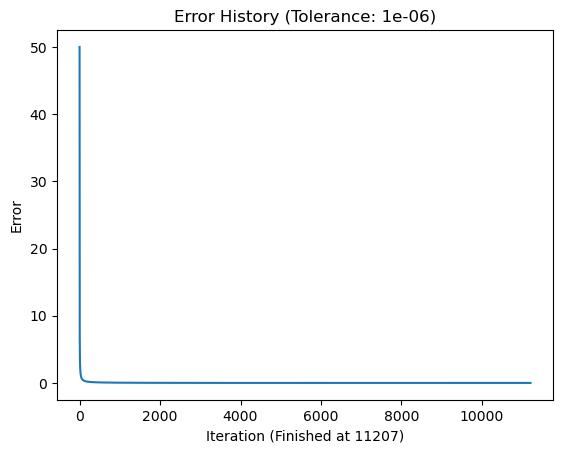

9.99184528893693e-07


In [50]:
model.show_error_history()
print(model.error_history[-1])

# SOR method

**Successive OverRelaxation** method

$$
\widetilde{\varphi}_{i,j}^{n+1} = \frac{1}{4} \left( \varphi_{i+1,j}^{n} + \textcolor{red}{\varphi_{i-1,j}^{n+1}} + \varphi_{i,j+1}^{n} + \textcolor{red}{\varphi_{i,j-1}^{n+1}} \right)
$$

$$
\varphi_{i,j}^{n+1} = \varphi_{i,j}^{n} + \textcolor{blue}{\omega} \left( \widetilde{\varphi}_{i,j}^{n+1} - \varphi_{i,j}^{n} \right)
$$

In [66]:
class SOR(GaussSeidel):
    def __init__(self, data_grid, error_threshold=1e-6, max_iterations=1000, omega=1.0):
        super().__init__(data_grid, error_threshold, max_iterations)
        self.omega = 2 / (1 + np.sin(np.pi * self.data_grid.h)) # optimal factor
    
    def update_factor(self):
        if self.argmax_error < 1e-3:
            # Under-relaxation
            self.omega = 0.7
        else:
            # Over-relaxation
            self.omega = 2 / (1 + np.sin(np.pi * self.data_grid.h)) # optimal factor
    
    def update(self):
        data_prev = self.data.copy()
        for i in range(1, self.N-1):
            for j in range(1, self.N-1):
                self.data[i, j] = self.omega * (self.data[i+1, j] + self.data[i-1, j] + self.data[i, j+1] + self.data[i, j-1]) / 4 + (1 - self.omega) * self.data[i, j]
        self.argmax_error = np.max(np.abs(self.data - data_prev))
        self.update_factor()
        self.error_history.append(self.argmax_error)
        if self.argmax_error < self.threshold:
            return True
        return False
    
    def train(self):
        start_time = time.time()
        for i in range(self.max_iterations):
            if self.update():
                end_time = time.time()
                self.running_time = end_time - start_time
                break
        return self.data, self.running_time
    
    def show_distribution(self):
        plt.imshow(self.data, cmap='jet')
        plt.xlabel('x')
        plt.ylabel('y')
        plt.title('Temperature Distribution')
        plt.colorbar()
        plt.show()
    
    def show_error_history(self):
        plt.plot(self.error_history)
        plt.xlabel('Iteration (Finished at {})'.format(len(self.error_history)))
        plt.ylabel('Error')
        plt.title('Error History (Tolerance: {})'.format(self.threshold))
        plt.show()



In [52]:
model = SOR(DataGrid(N), tolerance, max_iterations)
solution, Run_time_SOR = model.train()
print(f"Running time: {Run_time_SOR:.2f} seconds")
print(solution)

  0%|          | 0/50000 [00:00<?, ?it/s]

  1%|▏         | 691/50000 [00:04<05:16, 155.66it/s]

Running time: 4.44 seconds
[[5.00000000e+01 5.00000000e+01 5.00000000e+01 ... 5.00000000e+01
  5.00000000e+01 5.00000000e+01]
 [1.50000000e+02 9.99776657e+01 8.01900659e+01 ... 2.50111654e+01
  0.00000000e+00 0.00000000e+00]
 [1.50000000e+02 1.19720597e+02 9.99106629e+01 ... 1.51396804e+01
  0.00000000e+00 0.00000000e+00]
 ...
 [1.50000000e+02 7.49888339e+01 4.53297636e+01 ... 2.23315027e-02
  0.00000000e+00 0.00000000e+00]
 [1.50000000e+02 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [1.00000000e+02 1.00000000e+02 1.00000000e+02 ... 1.00000000e+02
  1.00000000e+02 1.00000000e+02]]


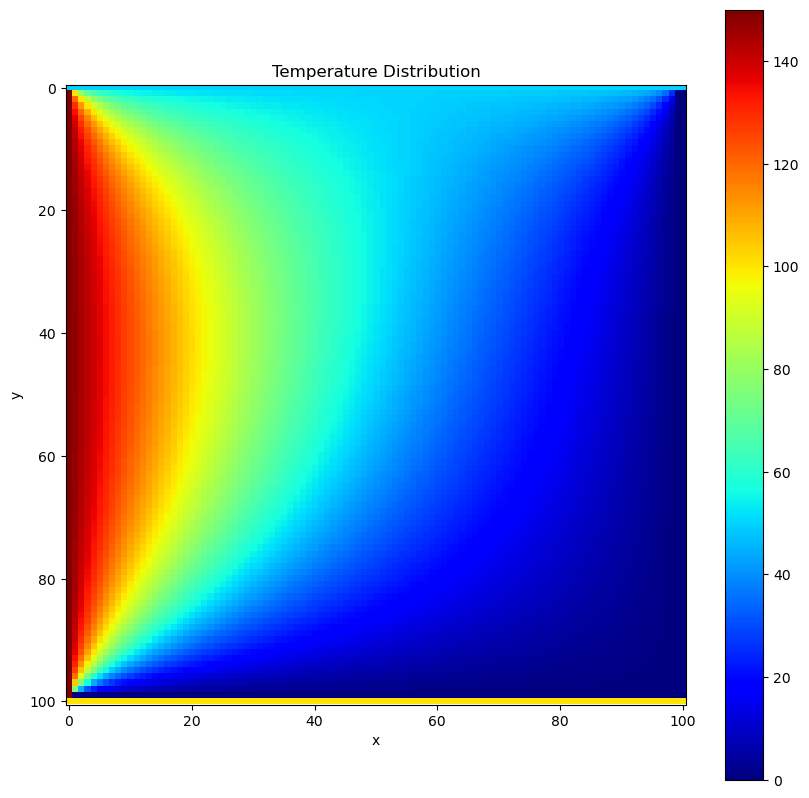

In [53]:
plt.figure(figsize=(10, 10))
model.show_distribution()

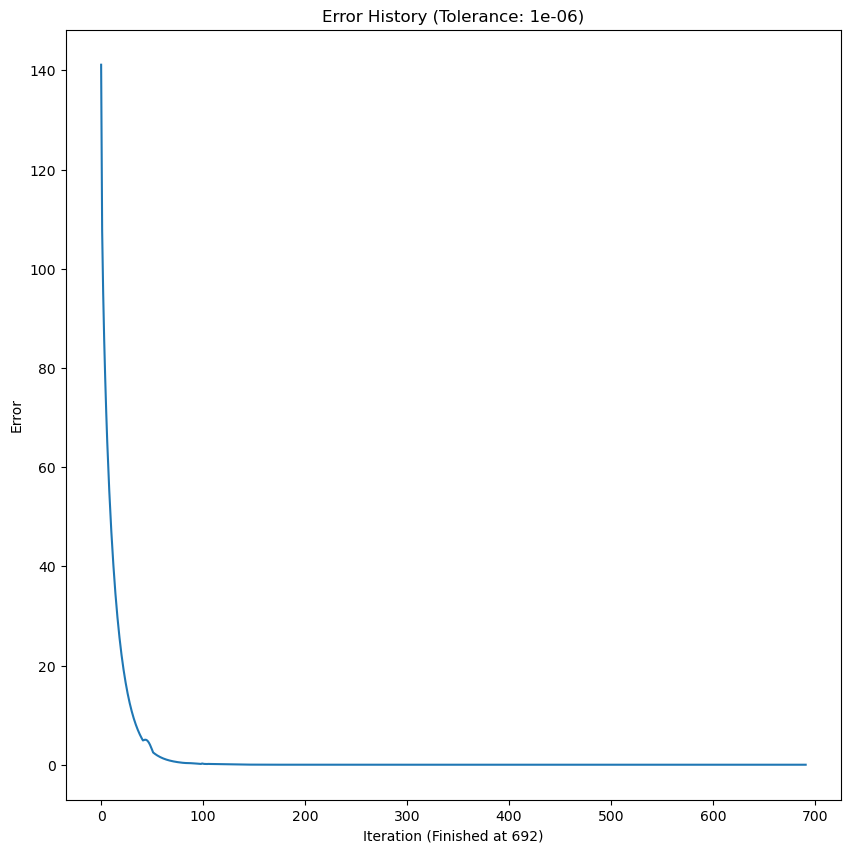

9.992684653070683e-07


In [54]:
plt.figure(figsize=(10, 10))
model.show_error_history()
print(model.error_history[-1])

# Comparison Results

Compare the results obtained from 1.-3. above in terms of computational time (relative to Jacobi iteration) as well as the trend in the temperature field.

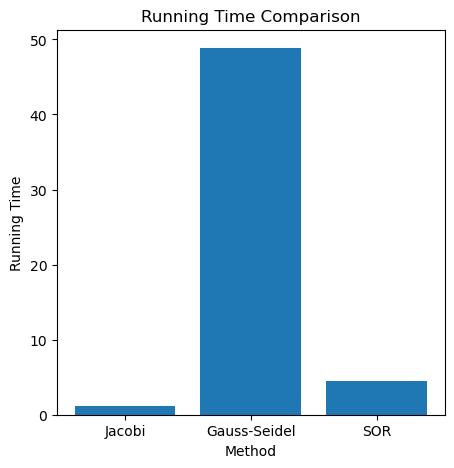

In [56]:
plt.figure(figsize=(5, 5))
plt.bar(['Jacobi', 'Gauss-Seidel', 'SOR'], [Run_time_Jacobi, Run_time_GaussSeidel, Run_time_SOR])
plt.xlabel('Method')
plt.ylabel('Running Time')
plt.title('Running Time Comparison')
plt.show()

# Monte Carlo method
Random walk -> Expectation value of BC values

In [110]:
import numpy as np
import matplotlib.pyplot as plt
import time
from tqdm import tqdm

class MonteCarlo_Laplace:
    def __init__(self, N, num_walks=100, max_iterations=1000):
        self.N = N # (N+2)x(N+2) grid
        self.h = 1 / N # grid size
        self.running_time = 0
        self.num_walks = num_walks
        self.T = np.zeros((N+2, N+2))
        self.T[:,0] = 150
        self.T[:,N+1] = 0
        self.T[0,:] = 100
        self.T[N+1,:] = 50
        self.max_iterations = max_iterations
    

    
    def get_points(self, x_start, y_start):
        reachable_points = []
        d = self.h / 10
        for _ in range(self.num_walks):
            x = x_start
            y = y_start
            for _ in range(self.max_iterations):
                dx = np.random.uniform(-d, d)
                dy = np.random.uniform(-d, d)
                x += dx
                y += dy
                if x <= 0:
                    reachable_points.append(150)
                    break
                elif x >= 1:
                    reachable_points.append(0)
                    break
                elif y <= 0:
                    reachable_points.append(100)
                    break
                elif y >= 1:
                    reachable_points.append(50)
                    break
                else:
                    pass
        value = np.mean(reachable_points)
        if value == None or value == np.nan or value == 0:
            print("No reachable points")
        return value if value else 0
    
    def get_distribution(self):
        start_time = time.time()
        xp = np.linspace(self.h, 1-self.h, self.N)
        yp = np.linspace(self.h, 1-self.h, self.N)
        for i, x in enumerate(xp):
            for j, y in enumerate(yp):
                self.T[j, i] = self.get_points(x, y)
        end_time = time.time()
        self.running_time = end_time - start_time
        print(f"Running time: {self.running_time} seconds")
    
    def show(self):
        plt.imshow(self.T, extent=[0, 1, 0, 1], origin='lower', cmap='viridis')
        plt.colorbar(label='Temperature')
        plt.xlabel('x')
        plt.ylabel('y')
        plt.title('Temperature Distribution of Monte Carlo Method')
        plt.show()


In [111]:
N = 10
num_walks = 1000
monte_carlo_model = MonteCarlo_Laplace(N, num_walks)
monte_carlo_model.get_distribution()

Running time: 163.73003220558167 seconds


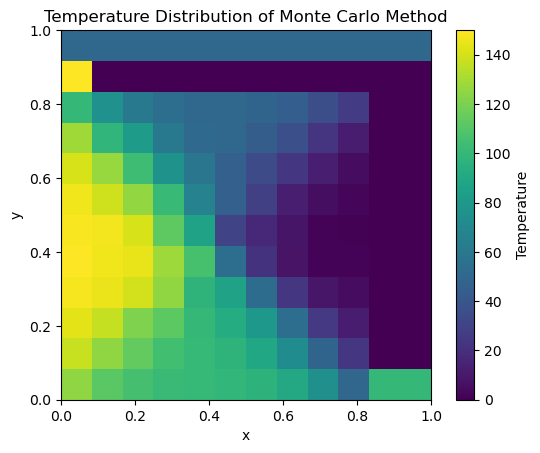

In [113]:
monte_carlo_model.show()

# PINN

In [ ]:
import torch.nn as nn
import torch
import numpy as np
import matplotlib.pyplot as plt

DEVICE = torch.device("mps") if torch.backends.mps.is_available() else torch.device("cpu")

class PINN(nn.Module):
    def __init__(self, data_grid, device=DEVICE):
        super(PINN, self).__init__()
        self.data_grid = data_grid
        self.N = data_grid.N
        self.device = device
        self.model = nn.Sequential(
            nn.Linear(2, 20,
            nn.Tanh(),
            nn.Linear(20, 20),
            nn.Tanh(),
            nn.Linear(20, 20),
            nn.Tanh(),
            nn.Linear(20, 20),
            nn.Tanh(),
            nn.Linear(20, 20),
            nn.Tanh(),
            nn.Linear(20, 1))
        
    def forward(self, x):
        return self.model(x)

class PINN_Optimizer(PINN):
    def __init__(self, data_grid, device=DEVICE):
        self.model = PINN(data_grid, device)
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=0.001)
        self.data_grid = data_grid
        self.device = device

    def train(self, num_epochs=1000):
        for epoch in range(num_epochs):
            self.optimizer.zero_grad()
            loss = self.loss_fn(self.model(self.data_grid.T), self.data_grid.T)
            loss.backward()
            self.optimizer.step()